In [14]:
# imports
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms, models
from torchvision.datasets import CIFAR10

import numpy as np
from abc import ABC, abstractmethod
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tqdm

In [2]:
cifar10 = CIFAR10('/data/benjamin.pikus', download=True,
    transform=transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

Files already downloaded and verified


In [5]:
train_dataset, test_dataset = torch.utils.data.random_split(
    cifar10, [int(len(cifar10)/2),int(len(cifar10)/2)], generator =torch.Generator().manual_seed(50))

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet18 = models.resnet18(pretrained=True).to(device)

In [17]:
minmaxhandler.clear_handles()

In [7]:
class SafeRegion(ABC):
    def __init__(self):
        self.hooks = {}
        self.train = True
        self.count_safe, self.count_notsafe = defaultdict(list), defaultdict(list)
    
    def clear_handles(self):
        for h in self.hooks.values():
            h.remove()
        self.hooks = {}
        self.count_safe, self.count_notsafe = defaultdict(list), defaultdict(list)
        
    @abstractmethod
    def get_activation(self, name):
        pass

In [8]:
class SimpleMinMax(SafeRegion):
    def __init__(self, generalize_ratio=0.0):
        super().__init__()
        self.min, self.max = float('inf'), float('-inf')
        self.generalize_ratio = generalize_ratio
        
    def get_activation(self, name):
        def count_safe(module, module_in):
            assert isinstance(module_in,tuple) and len(module_in) == 1
            module_in = module_in[0]
            mi = torch.min(module_in).item()
            ma = torch.max(module_in).item()
            if self.train:
                if mi < self.min:
                    self.min = mi
                if ma > self.max:
                    self.max = ma
            else:
                lower_lim, upper_lim = self.get_bounds()
                bounded_check = torch.logical_or(module_in < lower_lim, module_in > upper_lim)
                num_not_safe = torch.sum(bounded_check).item()
                num_all_samples =  torch.numel(bounded_check)
                num_safe = num_all_samples - num_not_safe
                self.count_safe[name].append(num_safe)#/num_all_samples)
                self.count_notsafe[name].append(num_not_safe)#/num_all_samples)
        return count_safe
    
    def get_bounds(self):
        if self.min < 0:
            lower_lim = self.min*(1+self.generalize_ratio)
        else:
            lower_lim = self.min*(1-self.generalize_ratio)
            
        if self.max < 0:
            upper_lim = self.max*(1-self.generalize_ratio)
        else:
            upper_lim = self.max*(1+self.generalize_ratio)
            
        return lower_lim, upper_lim

In [9]:
minmaxhandler_neg =
minmaxhandler_zer = SimpleMinMax(0)
minmaxhandler_pos = SimpleMinMax(0.9)
all_handlers = {
    "SimpleMinMax:-0.9" :  SimpleMinMax(-0.9),
    "SimpleMinMax:0" : SimpleMinMax(0),
    "SimpleMinMax:0.9" : SimpleMinMax(0.9)
}

In [19]:
all_handlers = {
    "Neg" : minmaxhandler_neg,
    "Zero" : minmaxhandler_zer,
    "Pos" : minmaxhandler_pos
}

In [10]:
def add_hooks(model, safe_region_counter):
    for layer_name,layer in model.named_modules():
        if isinstance(layer, torch.nn.modules.activation.ReLU):
            safe_region_counter.hooks[layer_name] = layer.register_forward_pre_hook(safe_region_counter.get_activation(layer_name))

In [15]:
def run_counter(model, dataset, safe_region_counters,
        train = True, batch_size=16, loader_workers=4):
    for s in safe_region_counters:
        s.train = train
    
    dataloader = DataLoader(
                dataset,
                batch_size=batch_size,
                shuffle=False,
                num_workers=loader_workers)
    
    for batch_samples, batch_labels in tqdm.tqdm(dataloader):
        batch_samples = batch_samples.to(device)
        with torch.no_grad():
            # just need to do a forward pass
            model(batch_samples)

In [12]:
for h in all_handlers.values():
    add_hooks(resnet18, h)

In [16]:
run_counter(resnet18, train_dataset, list(all_handlers.values()), train=True)

100%|██████████| 1563/1563 [01:41<00:00, 15.34it/s]


In [17]:
run_counter(resnet18, test_dataset, list(all_handlers.values()), train=False)

100%|██████████| 1563/1563 [03:55<00:00,  6.64it/s]


In [21]:
with torch.no_grad():
    model(dataset[0][0].unsqueeze(0).to(device))

In [22]:
minmaxhandler.train = False

In [18]:
for h in all_handlers:
    print(h.get_bounds())

(-1.4921607017517087, 2.496827697753906)
(-14.92160701751709, 24.968276977539062)
(-28.35105333328247, 47.43972625732422)


In [24]:
minmaxhandler.count_safe

defaultdict(list, {})

In [36]:
with torch.no_grad():
    model(dataset[0][0].unsqueeze(0).to(device))
minmaxhandler.count_safe

defaultdict(list,
            {'relu': [740740, 1476691, 740740],
             'layer1.0.relu': [182680, 175084, 362603, 279159, 182680, 175084],
             'layer1.1.relu': [182718, 153355, 365530, 247712, 182718, 153355],
             'layer2.0.relu': [94542, 87110, 188722, 175589, 94542, 87110],
             'layer2.1.relu': [88592, 90184, 176606, 180983, 88592, 90184],
             'layer3.0.relu': [46825, 45376, 93624, 91008, 46825, 45376],
             'layer3.1.relu': [44493, 46419, 89229, 93106, 44493, 46419],
             'layer4.0.relu': [22954, 16433, 45925, 33481, 22954, 16433],
             'layer4.1.relu': [22011, 7364, 44120, 15483, 22011, 7364]})

In [48]:
df = pd.DataFrame()

In [53]:
df[0] = 3
type(df)

pandas.core.frame.DataFrame

In [20]:
def add_safe_results(safe_region_counter):
    prob_safe_layer = []
    for layer_name, safe_counts in safe_region_counter.count_safe.items():
        unsafe_counts = safe_region_counter.count_notsafe[layer_name]
        if layer_name == 'relu':
            prob_safe_layer.append(sum(safe_counts) / (sum(safe_counts) + sum(unsafe_counts)))
        else:
            # torchvision implementation of resnet calls each relu in the basicblock layer twice
            num_safe1, num_safe2 = 0,0
            num_notsafe1, num_notsafe2 = 0,0
            assert len(safe_counts)%2 == 0
            for i in range(0,len(safe_counts),2):
                num_safe1 += safe_counts[i]
                num_safe2 += safe_counts[i+1]
                num_notsafe1 += unsafe_counts[i]
                num_notsafe2 += unsafe_counts[i+1]
            prob_safe_layer.append(num_safe1 / (num_safe1 + num_notsafe1))
            prob_safe_layer.append(num_safe2 / (num_safe2 + num_notsafe2))
    return prob_safe_layer

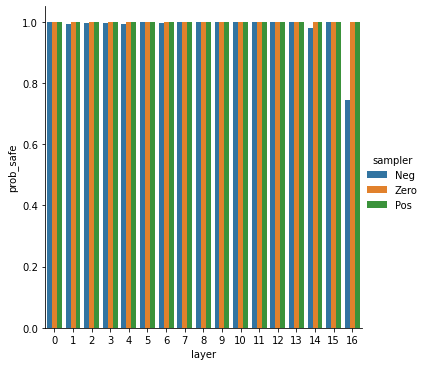

In [21]:
prob_safe_df =pd.DataFrame()
for k,v in all_handlers.items():
    prob_safe_df[k] = add_safe_results(v)
prob_safe_df['layer'] = range(prob_safe_df.shape[0])
prob_safe_df = pd.melt(prob_safe_df, id_vars="layer", var_name="sampler", value_name="prob_safe")
sns.catplot(data = prob_safe_df, x = 'layer', y = 'prob_safe', hue = 'sampler', kind = 'bar')

In [12]:
a = dataset[0][0].unsqueeze(0).to(device)
torch.min(a).item()

-2.1179039478302

In [31]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cl1 = nn.Linear(25, 60)
        self.cl2 = nn.Linear(60, 16)
        self.fc1 = nn.Linear(16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.relu(self.cl1(x))
        x = F.relu(self.cl2(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


model = MyModel()
model.fc2.register_forward_hook(get_activation('fc2'))
model.fc1.register_forward_hook(get_activation('fc1'))
x = torch.randn(1, 25)
output = model(x)
print(activation.keys())

dict_keys(['fc1', 'fc2'])


In [33]:
activation['fc1'].shape

torch.Size([1, 120])

In [56]:
df = pd.DataFrame()
df['name'] = prob_safe_layer
df

,name
0,0.921186
1,0.906762
2,0.783899
3,0.910503
4,0.690597
5,0.941202
6,0.871455
7,0.881373
8,0.900209
9,0.933086
